<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/Exercise_metrics_Insurance_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Exercise: Metrics**
---

**Study case: 'insurance' dataset**

Find the best model and hyperparameters to predict insurance costs for each individual based on their characteristics.
1. Perform a brief EDA to explore the dataset first.
2. Preprocess the features if needed.
3. Perform modeling using lasso regression, knn regressor, and decision tree regressor.

Candidate algorithms:
- lasso = Lasso(alpha=1)
- knn = KNeighborsRegressor(n_neighbors=5)
- tree = DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=1, max_depth=5, random_state=0)
4. Select the best model based on the cross-validation results of the three models above.
5. Perform hyperparameter tuning on the selected model.
6. Make predictions on the test set of the selected model (before hyperparameter tuning).
7. Make predictions on the test set of the model with hyperparameter tuning.
8. Compare the model performance results before and after tuning.

*Tip: Use Pipeline*

### **Initial Setup**

In [57]:
# Install additional
# !pip install category_encoders

In [58]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Splitting
from sklearn.model_selection import train_test_split, cross_val_score

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# ML algorithm
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn.metrics import mean_absolute_error

In [59]:
# ggplot style
plt.style.use('ggplot')

# warnings
import warnings
warnings.filterwarnings('ignore')

## **Data Understanding**

- The dataset describes 1,338 individuals.
- Each row represents information/characteristics of the individual, such as age, gender, body mass index, and others, along with information on the amount of the insurance claim.

In [60]:
# Loading dataset
url = 'https://raw.githubusercontent.com/harishmuh/machine_learning_practices/refs/heads/main/datasets/insurance.csv'
data = pd.read_csv(url)
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [61]:
# Data summary
print(f'Number of rows and columns {data.shape}')

Number of rows and columns (1338, 7)


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


**Attribute Information**

| Attribute | Data Type | Description |
| --- | --- | --- |
|age |Integer | age of primary beneficiary |
|sex |Text | insurance contractor gender, female, male |
|bmi |Float | Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9 |
|children |Integer| Number of children covered by health insurance / Number of dependents |
|smoker |Text | Smoking |
|region |Text | the beneficiary's residential area in the US, northeast, southeast, southwest, northwest. |
|charges |Float | Individual medical costs billed by health insurance |

**Initial Assesment**

In [63]:
# Check data type, null values, and unique values ​​of each column
pd.DataFrame({
    'feature': data.columns.values,
    'data_type': data.dtypes.values,
    'null': data.isna().mean().values * 100,
    'negative': [True if data[col].dtype == int and (data[col] < 0).any() else False for col in data.columns],
    'n_unique': data.nunique().values,
    'sample_unique': [data[col].unique() for col in data.columns]
})

,feature,data_type,null,negative,n_unique,sample_unique
0,age,int64,0.0,False,47,"[19, 18, 28, 33, 32, 31, 46, 37, 60, 25, 62, 2..."
1,sex,object,0.0,False,2,"[female, male]"
2,bmi,float64,0.0,False,548,"[27.9, 33.77, 33.0, 22.705, 28.88, 25.74, 33.4..."
3,children,int64,0.0,False,6,"[0, 1, 3, 2, 5, 4]"
4,smoker,object,0.0,False,2,"[yes, no]"
5,region,object,0.0,False,4,"[southwest, southeast, northwest, northeast]"
6,charges,float64,0.0,False,1337,"[16884.924, 1725.5523, 4449.462, 21984.47061, ..."


**Descriptive Statistics**

In [64]:
display(data.describe(), data.describe(include='object'))

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


### **Exploratory Data Analysis (EDA)**

#### `Numerical Features`

**Data Distribution**

In [65]:
numerical = [var for var in data.columns if data[var].dtypes not in ['object', 'bool']]

In [66]:
# Normality test
from scipy.stats import normaltest

dist = []

for i in range(len(numerical)):
    feature_name = numerical[i]
    stat, p_value = normaltest(data[feature_name].dropna())

    if p_value > 0.05:
        distribution = "Normally Distributed"
    else:
        distribution = "Not Normally Distributed"

    dist.append([feature_name, stat, p_value, distribution])

dist_df = pd.DataFrame(dist, columns=['Feature', "D'Agostino-Pearson Statistic", 'P-value', 'Distributed'])
dist_df

,Feature,D'Agostino-Pearson Statistic,P-value,Distributed
0,age,1557.820581,0.000000e+00,Not Normally Distributed
1,bmi,17.581448,1.521378e-04,Not Normally Distributed
2,children,147.700416,8.457893e-33,Not Normally Distributed
3,charges,336.885122,7.019808e-74,Not Normally Distributed


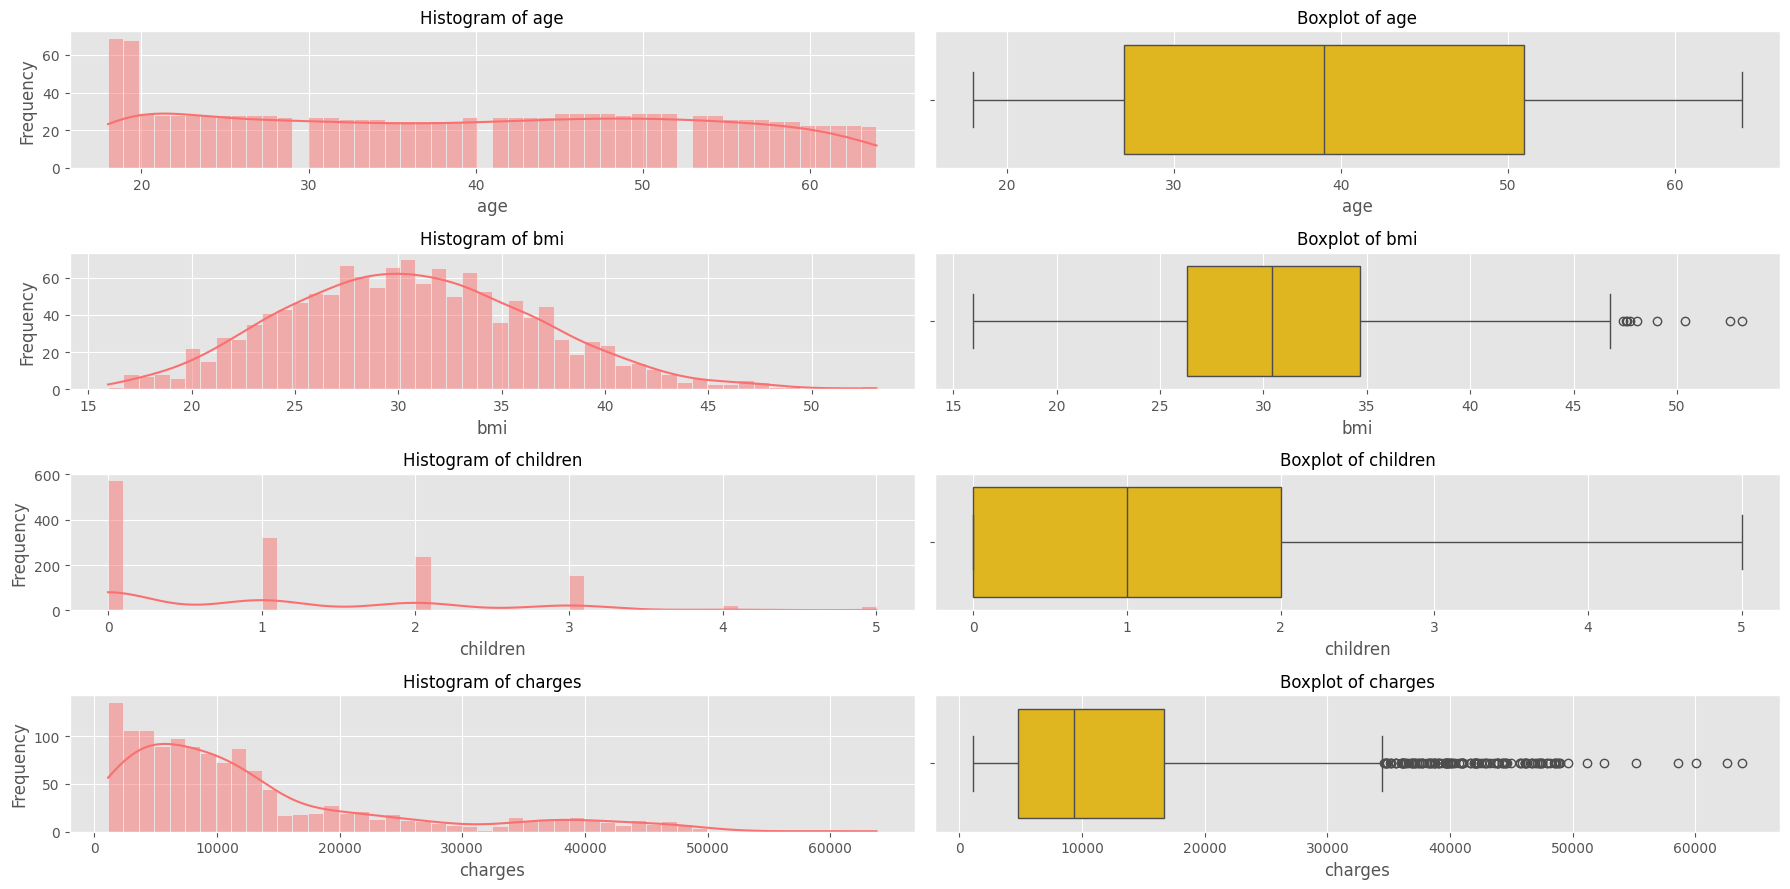

In [67]:
plt.figure(figsize=(18, 9))

for index, col in enumerate(numerical):
    # Histogram
    plt.subplot(len(numerical), 2, index * 2 + 1)
    sns.histplot(data[col], kde=True, color='#FA7070', bins=50)
    plt.title(f'Histogram of {col}', size=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(len(numerical), 2, index * 2 + 2)
    sns.boxplot(x=data[col], color='#FFC700')
    plt.title(f'Boxplot of {col}', size=12)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

**Correlation**

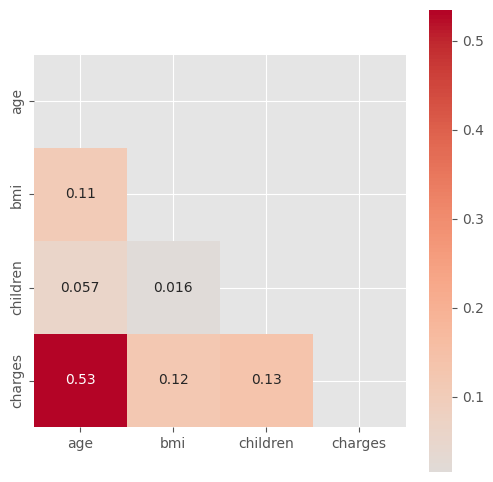

In [68]:
# Correlation
plt.figure(figsize=(6, 6))

matrix = np.triu(data.select_dtypes(['int', 'float']).corr(method='spearman'))

sns.heatmap(data=data.select_dtypes(['int', 'float']).corr(method='spearman'), annot=True, cmap='coolwarm', center=0, mask = matrix, square='True')
plt.show()

**Feature vs Target**

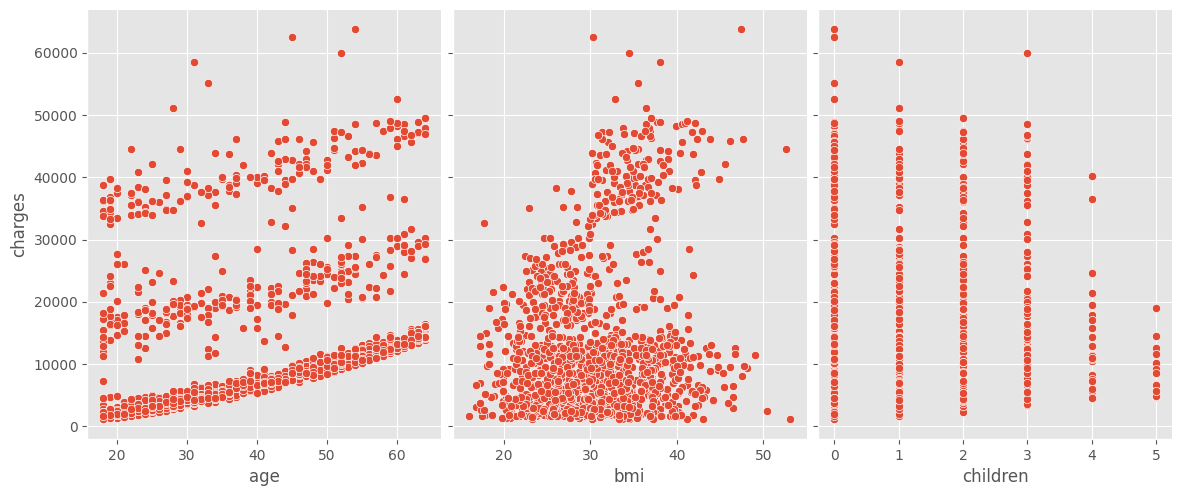

In [69]:
sns.pairplot(data, x_vars=['age', 'bmi', 'children'], y_vars='charges', height=5, aspect=0.8)
plt.show()

#### `Categorical Features`

**Distribution**

In [70]:
categorical = [var for var in data.columns if data[var].dtypes in ['object', 'bool']]

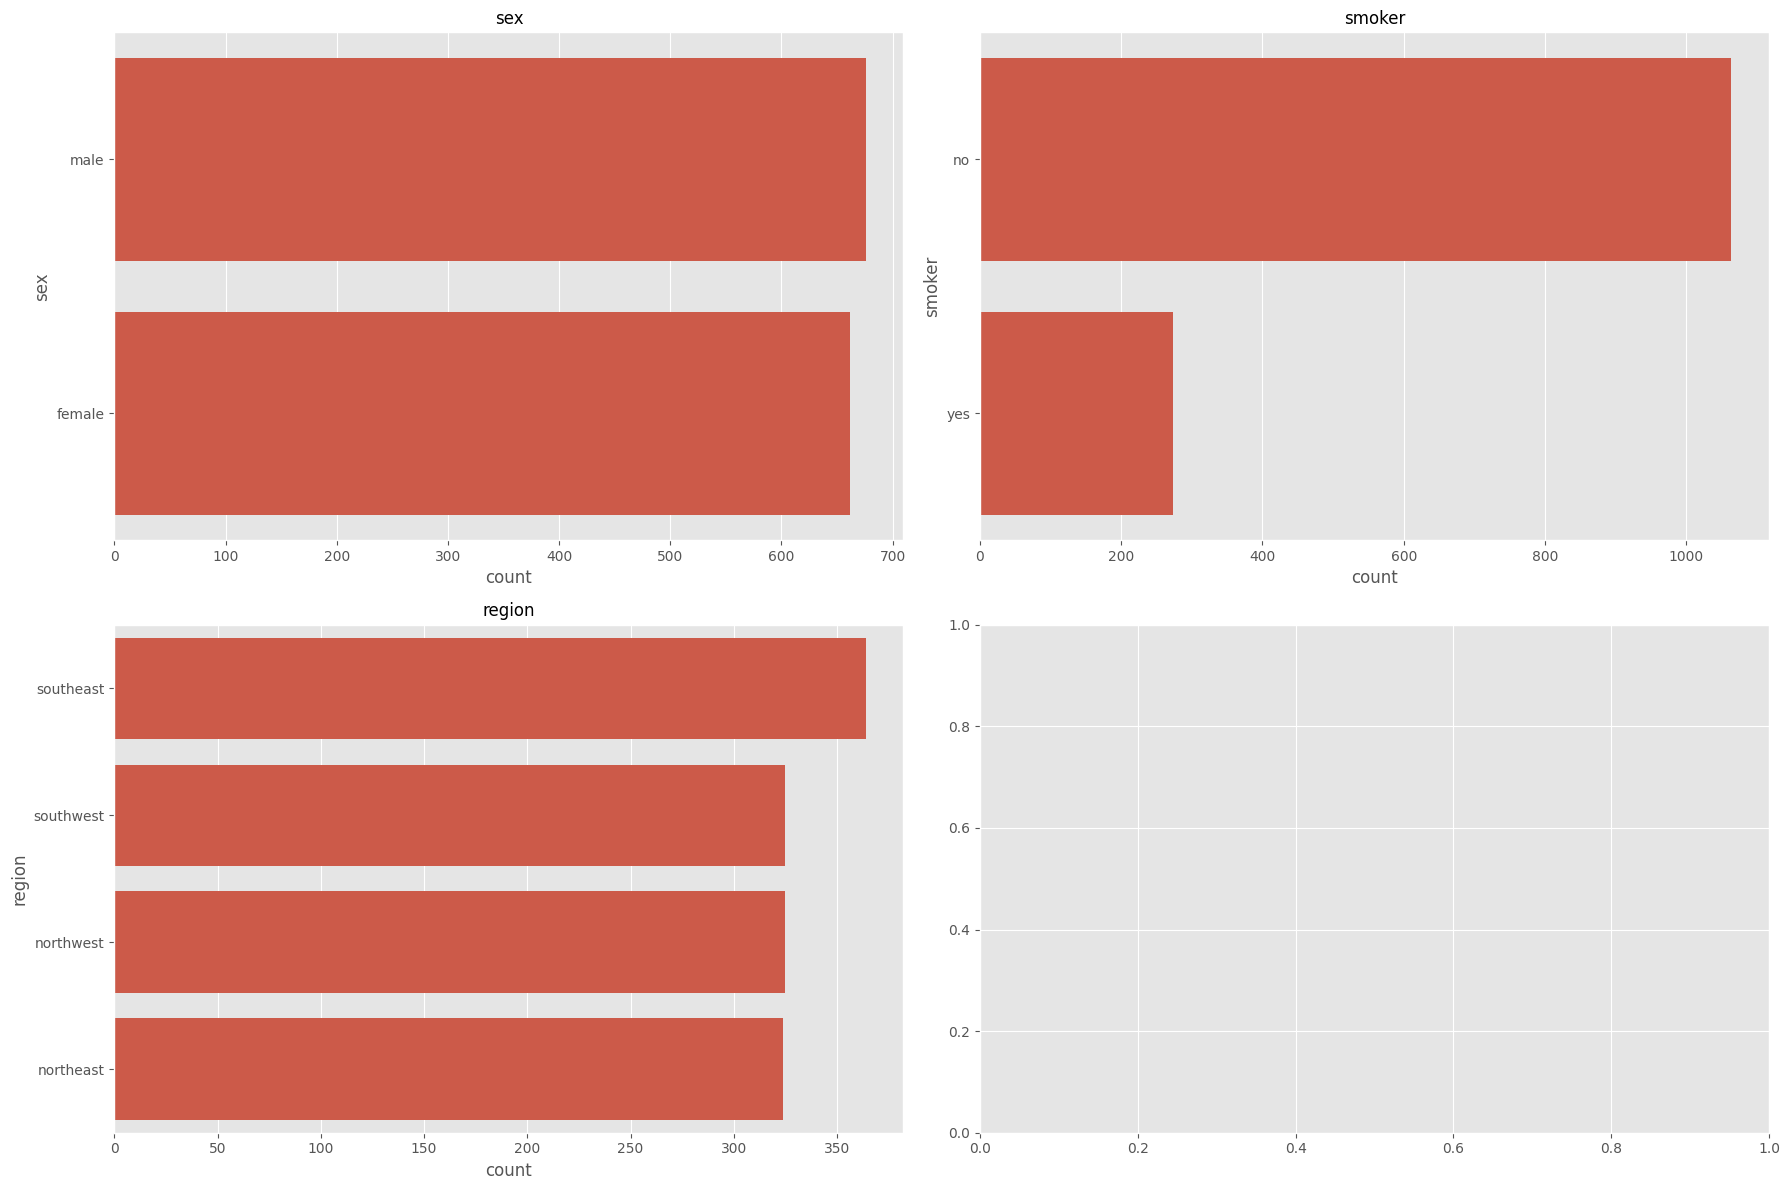

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for i, j in zip(categorical, axes.flatten()):
    ax = sns.countplot(data=data, y= i, ax= j, order=data[i].value_counts().index)
    ax.set_title(f'{i}', size = 12)

plt.tight_layout()
plt.show()

**Feature vs Target**

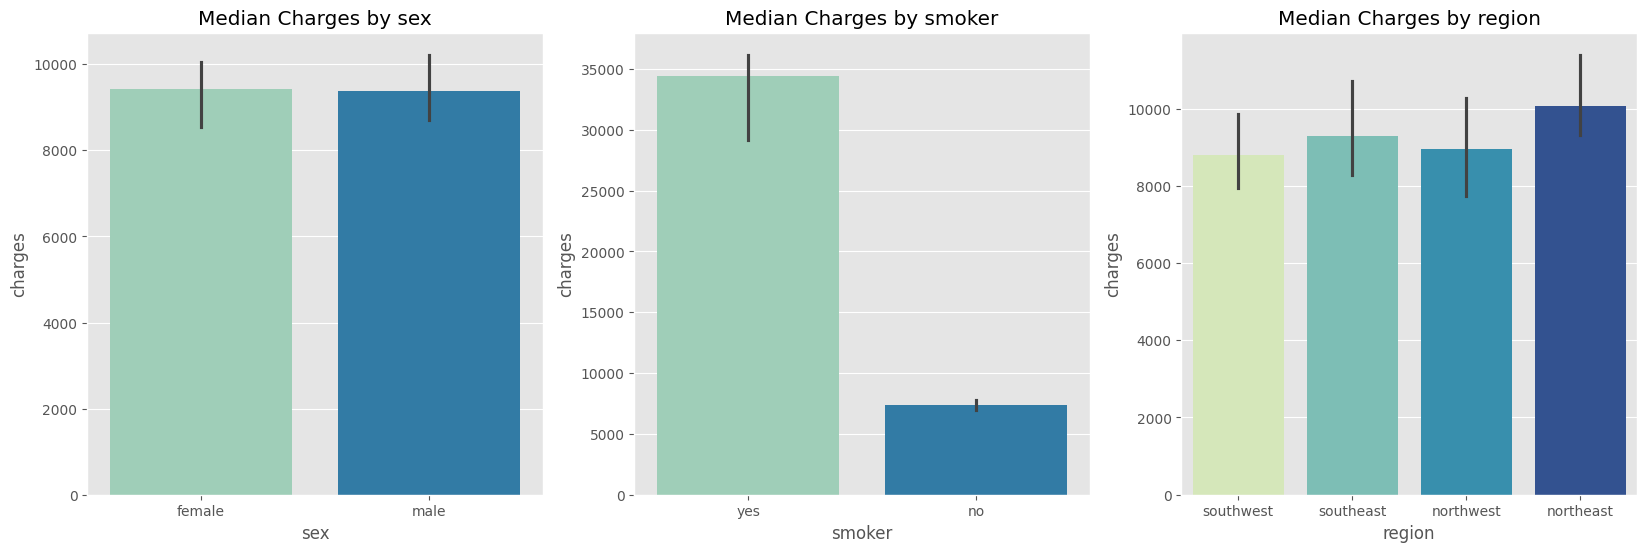

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))

for i, column in enumerate(categorical):
    sns.barplot(data=data, x=column, y='charges', estimator=np.median, ax=axes[i], palette='YlGnBu')
    axes[i].set_title(f'Median Charges by {column}')

plt.show()

### **Data Preprocessing**

#### `Duplicates`

In [73]:
print(f"Number of duplicated data: {data[data.duplicated()].shape}")
print(f'Percentage of {len(data[data.duplicated()])/len(data)*100:.2f}%')

Number of duplicated data: (1, 7)
Percentage of 0.07%


`Handling duplicates`

In [74]:
data.drop_duplicates(keep='last', inplace=True, ignore_index=True)

#### `Missing Values`

In [75]:
pd.DataFrame({'Missing values': [data[col].isna().sum() for col in data.columns]}, index=data.columns.values)

,Missing values
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


#### `Outliers`

In [76]:
# Calculating outliers
def calculate_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_data = []

numerical = [var for var in data.columns if data[var].dtypes != 'object']

for column in numerical:
    outlier_result, lower_bound, upper_bound = calculate_outliers(data, column)
    total_outlier = len(outlier_result)
    outlier_percentage = round(total_outlier / len(data[column]) * 100, 2)
    outlier_data.append([column, total_outlier, outlier_percentage, lower_bound, upper_bound])

outlier_df = pd.DataFrame(outlier_data, columns=["Column", "Total Outliers", "Percentage (%)", "Lower Bound", "Upper Bound"])
outlier_df

,Column,Total Outliers,Percentage (%),Lower Bound,Upper Bound
0,age,0,0.00,-9.000000,87.000000
1,bmi,9,0.67,13.675000,47.315000
2,children,0,0.00,-3.000000,5.000000
3,charges,139,10.40,-13120.716175,34524.777625


There are outliers in the numerical columns with percentages ranging from 0% to 10.4%, with the highest percentage in the charges column, which is the target. Since the outlier is in the temporary target, we'll leave it alone for now.

#### `Collinearity`

In [77]:
def calculate_vif(data):
    vif = pd.DataFrame()
    vif['Feature'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.dropna(), i) for i in range(len(data.columns))]

    return vif.sort_values('VIF', ascending=False)

We will carry out repeated testing until we obtain a VIF value < 10.

In [78]:
vif_df = calculate_vif(data[numerical])
dropped_columns = []

for i in range(len(vif_df)):
    if vif_df.iloc[0, -1] < 10:
        break
    else:
        dropped_columns.append(vif_df.iloc[0, 0])
        vif_df = calculate_vif(data[numerical].drop(columns=dropped_columns))

In [79]:
vif_df

,Feature,VIF
0,age,8.102351
1,bmi,8.056432
3,charges,2.474252
2,children,1.800697


In [80]:
dropped_columns

[]

There is no multicollinearity

#### `Cardinality`

In [81]:
categorical = [var for var in data.columns if data[var].dtypes == 'object']

In [82]:
# creating a function to check cardinality
def check_cardinality(data):
    for feature in categorical:
        cardinality = len(data[feature].unique())
        print(f"Cardinality of {feature}: {cardinality}")

        if cardinality > 10:
            print(f"Warning: High cardinality in {feature}.")

check_cardinality(data)

Cardinality of sex: 2
Cardinality of smoker: 2
Cardinality of region: 4


#### `Feature Engineering`

**Encoding**

Now let's encode our categorical features.
Here's what we'll do:

1. Convert the features/columns `sex, smoker,` and `region` using One Hot Encoding, as these features are not ordered/ordinal and have a small number of unique data points.

**Scaling**

We will use the `Robust Scaler` because our data contains outliers, and the Robust Scaler will not be affected by outliers. We can reset the scaler later to find the best scaler.

### **Modeling**

#### `Define Features (X) and Target (y)`

In [83]:
# feature
X = data.drop(columns='charges')

# target
y = data['charges']

#### `Data Splitting`

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0,
)

#### `Pipeline`

| Technique | Action |
| ----------------------------- | ----------- |
| One Hot Encoding | Transform the `sex, smoker, and region` columns with the number of unique values ​​<= 10 |
| Robust Scaling | Scale transformation of each feature using a robust scaler |

In [85]:
# Column Transformer
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop='first'), ['sex', 'smoker', 'region'])
], remainder='passthrough')

In [86]:
# Scaling
scaler = RobustScaler()

#### `Model Selection`

In [87]:
# Define models (3 candidate models)
lasso = Lasso(alpha=1)
knn = KNeighborsRegressor(n_neighbors=5)
dtree = DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=1, max_depth=5, random_state=0)

In [88]:
# Model Selection
models = [lasso, knn, dtree]

mae_mean = []
mae_std = []
all_mae = []
model_name = []

# Find the best model based on the smallest mean mae score and smallest std
for algoritma in models:

    model_pipe = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('model', algoritma)])

    model_cv = cross_val_score(
        model_pipe,                 # model already entered into the pipeline
        X_train,                    # data before preprocessing
        y_train,
        cv = 5,
        scoring = 'neg_mean_absolute_error'
        )

    mae_mean.append(model_cv.mean())
    mae_std.append(model_cv.std())
    all_mae.append(model_cv.round(4))
    model_name.append(algoritma.__class__.__name__)

In [89]:
# Comparison of MAE scores for each algorithm
pd.DataFrame({
    'model': model_name,
    'mean': mae_mean,
    'std': mae_std,
    'all_score' : all_mae
}).sort_values('mean', ascending=False)

,model,mean,std,all_score
2,DecisionTreeRegressor,-1946.889512,318.182747,"[-1533.0814, -2451.5422, -2069.4451, -1985.963..."
1,KNeighborsRegressor,-3602.850733,252.013572,"[-3359.9336, -4038.9573, -3718.7287, -3508.181..."
0,Lasso,-4019.201913,329.966733,"[-3627.3746, -4589.026, -4151.3644, -3881.3814..."


*Predict Benchmark Model to Test Set*

In [90]:
list_mae_score = []

# Find the best model based on the largest f1 score and the smallest std
for algoritma in models :

    model_pipe=Pipeline([
        ('preprocess', transformer),
        ('scaler', scaler),
        ('model', algoritma)
    ])

    # fitting
    model_pipe.fit(X_train, y_train)

    # predict
    y_pred = model_pipe.predict(X_test)

    # evaluate
    score = mean_absolute_error(y_test, y_pred)
    list_mae_score.append(score)

In [91]:
# Performance comparison between models
pd.DataFrame({
    'model': model_name,
    'accuracy (test_set)': list_mae_score
})

,model,accuracy (test_set)
0,Lasso,4499.158363
1,KNeighborsRegressor,3634.780102
2,DecisionTreeRegressor,2325.880158


**Insight**

- Of the three models tested, the decision tree regressor model produced the smallest error, with a significant difference.
- The decision tree regressor was also quite stable, although Lasso was slightly more stable.
- Furthermore, the decision tree regressor performed equally well on both the train and test sets.

#### `Hyperparameter Tuning`

In [92]:
# hyperparameters candidates
param_grid = {
    'model__criterion':['absolute_error','squared_error'],
    'model__min_samples_leaf': [1, 5, 10, 15, 20, 50],
    'model__max_depth':[5, 6, 7, 8, 9, 10]
}

In [93]:
from sklearn.model_selection import RandomizedSearchCV

# model benchmark
dtree = DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=1, max_depth=5, random_state=0)

# model in pipeline
tree_pipeline = Pipeline([
    ('preprocess', transformer),
    ('scaler', scaler),
    ('model', dtree)
])

# Grid search (find best hypermater)
tuned_model = GridSearchCV(
    estimator = tree_pipeline,
    param_grid = param_grid,
    cv = 5,
    scoring = 'neg_mean_absolute_error',
    n_jobs= -1,
)

# fit tuned_model on train set
tuned_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('scaler', RobustScaler()),
                                       ('model',
                                        DecisionTreeRegressor(criterion='absolute_error',
                                                              max_depth=5,
                                                              random_state=0))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['absolute_error',
                                              'squared_error'],
                         'model__max_depth': [5, 6, 7, 8, 9, 10],
                         'model__min_samples_leaf': [1, 5, 10, 15, 20, 50]},
             scoring='neg_mean_absolute_error')

In [94]:
# Best score from grid_search
print(f'MAE on train set: {tuned_model.best_score_:.3f}')

# Hyperparameters for the best score from tuned_model
print(f'Best parameter: {tuned_model.best_params_}')

MAE on train set: -1771.788
Best parameter: {'model__criterion': 'absolute_error', 'model__max_depth': 9, 'model__min_samples_leaf': 5}


In [95]:
pd.DataFrame(tuned_model.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,0.081872,0.018748,0.015460,0.003901,absolute_error,9,5,"{'model__criterion': 'absolute_error', 'model_...",-1423.028567,-2126.100746,-1968.385997,-1812.775593,-1528.649887,-1771.788158,263.293586,1
19,0.088076,0.029645,0.017982,0.005669,absolute_error,8,5,"{'model__criterion': 'absolute_error', 'model_...",-1427.945939,-2133.954798,-1977.980305,-1821.190785,-1528.421943,-1777.898754,265.852736,2
13,0.095585,0.032739,0.012469,0.003788,absolute_error,7,5,"{'model__criterion': 'absolute_error', 'model_...",-1441.083612,-2158.291813,-1935.842707,-1812.924435,-1558.535837,-1781.335681,257.828407,3
31,0.104021,0.025696,0.019341,0.004900,absolute_error,10,5,"{'model__criterion': 'absolute_error', 'model_...",-1417.317198,-2128.922041,-2058.814437,-1932.563646,-1513.935562,-1810.310577,289.998342,4
26,0.115506,0.011866,0.022569,0.006786,absolute_error,9,10,"{'model__criterion': 'absolute_error', 'model_...",-1401.580010,-2270.735556,-1956.500099,-1793.420703,-1655.592894,-1815.565852,291.378775,5


**Predict Tuned Model to Test Set**

In [96]:
tuned_model.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('scaler', RobustScaler()),
                ('model',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=9,
                                       min_samples_leaf=5, random_state=0))])

In [97]:
# Model after hyperparameter tuning
best_model = tuned_model.best_estimator_

# Fitting model
best_model.fit(X_train, y_train)

# Predict to test set
y_pred_best = best_model.predict(X_test)

# Evaluate MAE score on test set
print(f'MAE on test set: {mean_absolute_error(y_test, y_pred_best):.3f}')

MAE on test set: 2258.831


| MAE Score | Train Set | Test Set |
| --- | --- | --- |
| Before Tuning | 1946.889 | 2325.880 |
| After Tuning | 1771.788 | 2258.831 |

Insight

- The model selected for modeling this dataset is the Decision Tree Regressor.
- Hyperparameter tuning successfully improved the performance of the Decision Tree model based on MAE.
- The best hyperparameters based on RandomizedSearch are {'model__criterion': 'absolute_error', 'model__max_depth': 9, 'model__min_samples_leaf': 5}**

#### `Model Evaluation`

**Plot Tree**

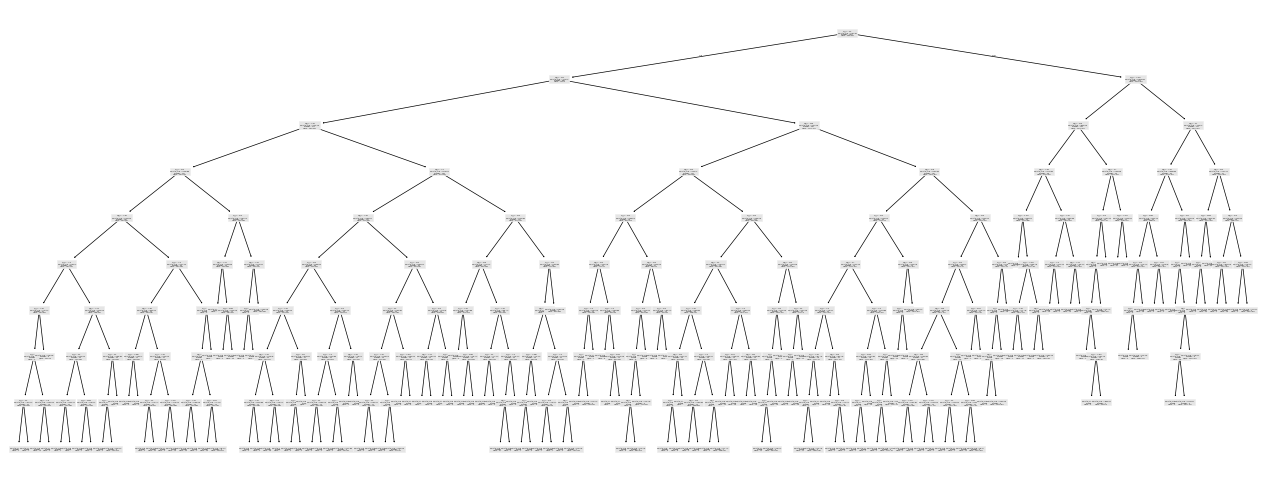

In [98]:
from sklearn.tree import plot_tree

plt.figure(figsize=(16,6))
plot_tree(decision_tree=best_model['model'])
plt.show()

**Feature Importances**

In [99]:
onehot_features = transformer.transformers_[0][1].get_feature_names_out().tolist()
remainder_features = X.columns[transformer.transformers_[1][2]].tolist()

feature_names = onehot_features + remainder_features

In [100]:
df_feature_importances = pd.DataFrame({
    "feature" : feature_names,
    "importance" : best_model['model'].feature_importances_
}).sort_values(by='importance', ascending=False)

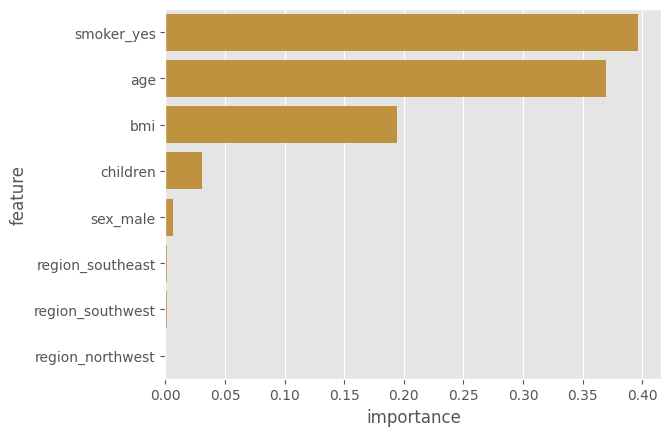

In [101]:
sns.barplot(data=df_feature_importances, x='importance', y='feature', color='orange', saturation=0.5)
plt.show()

**Actual vs Prediction Scatterplot**

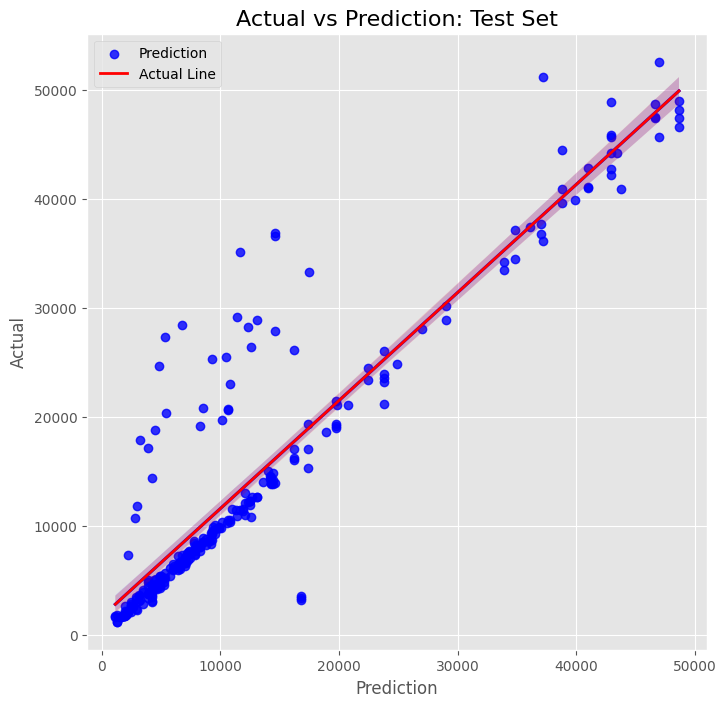

In [102]:
plt.figure(figsize=(8,8))

sns.regplot(y=y_test, x=y_pred_best, color='blue', label='Prediction')
sns.regplot(y=y_test, x=y_pred_best, line_kws = {'linewidth': 2}, scatter=False, color='red', label='Actual Line')

plt.title('Actual vs Prediction: Test Set', fontsize=16)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.legend()
plt.show()

In [103]:
evaluation_df = pd.DataFrame({
    'actual value': y_test.reset_index(drop=True),
    'predicted value': y_pred_best
})

In [104]:
def segmentation(x):
    if x <= 5000:
        return '<5K'
    elif x <= 10000:
        return '5K-10K'
    elif x <= 15000:
        return '10K-15K'
    elif x <= 20000:
        return '15K-20K'
    elif x <= 25000:
        return '20K-25K'
    elif x <= 30000:
        return '25K-30K'
    elif x <= 35000:
        return '30K-35K'
    elif x <= 40000:
        return '35K-40K'
    elif x <= 45000:
        return '40K-45K'
    else:
        return '>45K'

evaluation_df['group'] = evaluation_df['predicted value'].apply(segmentation)

In [105]:
label = ['<5K', '5K-10K', '10K-15K', '15K-20K', '20K-25K',
         '25K-30K', '30K-35K', '35K-40K', '40K-45K', '>45K']

In [106]:
score = []
for group in label:
    data = evaluation_df[evaluation_df['group']==group]
    mae = mean_absolute_error(data['actual value'], data['predicted value'])
    score.append(mae)

mae_df = pd.DataFrame({
    'group': label,
    'mae': score
})

mae_df

,group,mae
0,<5K,1514.606902
1,5K-10K,1493.536035
2,10K-15K,4504.814525
3,15K-20K,4491.443845
4,20K-25K,1019.709689
5,25K-30K,793.230583
6,30K-35K,859.823350
7,35K-40K,2890.869891
8,40K-45K,1770.215999
9,>45K,1630.246254


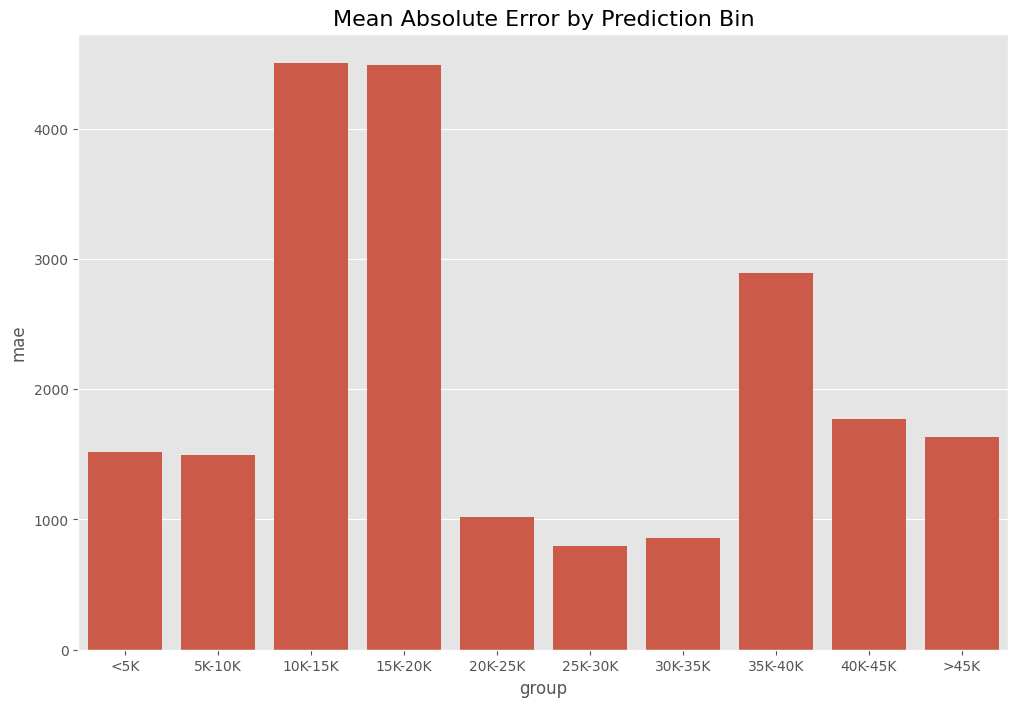

In [107]:
plt.figure(figsize=(12,8))
sns.barplot(data=mae_df, x='group', y='mae')
plt.title('Mean Absolute Error by Prediction Bin', size=16)
plt.show()

**Model Limitations**:

The model is only valid for the following inputs:

- **Age**: between 18 and 64
- **BMI**: between 15.96 and 53.13
- **Children**: between 0 and 5
- **Sex**: male and female
- **Smoker**: yes and no
- **Region**: southwest, southeast, northwest, and northeast

In [108]:
display(X.describe(), X.describe(include='object'))

,age,bmi,children
count,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737
std,14.044333,6.100468,1.205571
min,18.000000,15.960000,0.000000
25%,27.000000,26.290000,0.000000
50%,39.000000,30.400000,1.000000
75%,51.000000,34.700000,2.000000
max,64.000000,53.130000,5.000000


,sex,smoker,region
count,1337,1337,1337
unique,2,2,4
top,male,no,southeast
freq,675,1063,364
